In [1]:
# Ячейка 1: Импорты и настройка
import sys
sys.path.append('..')

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import time
import json

from src.dataset import STEM4DDataset, create_data_loaders
from src.model import UNetDenoiser, SimpleDenoisingCNN
from src.losses import PoissonNLLLoss, CombinedLoss, calculate_metrics

# Настройки
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Для воспроизводимости
torch.manual_seed(42)
np.random.seed(42)

Using device: cpu


Loading data...
Data shape: (256, 256, 48, 48)
Bright field pixels: 1812 / 2304


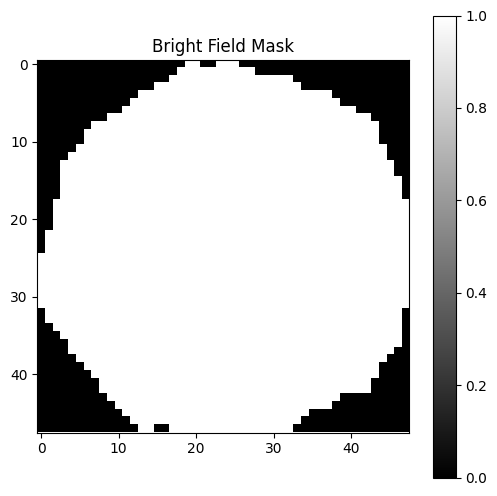

In [2]:
# Ячейка 2: Загрузка и подготовка данных
data_path = Path("../data")
results_path = Path("../results")

# Загрузка данных
print("Loading data...")
low_dose = np.load(data_path / "03_denoising_SrTiO3_High_mag_Low_dose.npy")
high_dose = np.load(data_path / "03_denoising_SrTiO3_High_mag_High_dose.npy")
print(f"Data shape: {low_dose.shape}")

# Создание bright field маски
pacbed = np.mean(high_dose, axis=(0, 1))
bf_threshold = 0.1 * pacbed.max()
bf_mask = pacbed > bf_threshold
print(f"Bright field pixels: {bf_mask.sum()} / {bf_mask.size}")

# Визуализация маски
plt.figure(figsize=(6, 6))
plt.imshow(bf_mask, cmap='gray')
plt.title('Bright Field Mask')
plt.colorbar()
plt.show()

In [3]:
# Ячейка 3: Создание DataLoaders
# Для CPU используем меньший batch size
batch_size = 8  # Маленький batch для экономии памяти
num_workers = 0  # Для Windows лучше 0

train_loader, val_loader = create_data_loaders(
    low_dose, 
    high_dose,  # используем как clean data
    batch_size=batch_size,
    val_split=0.1,
    bright_field_mask=bf_mask,
    num_workers=num_workers
)

print(f"Training samples: {len(train_loader.dataset)}")
print(f"Validation samples: {len(val_loader.dataset)}")

# Проверка одного батча
sample_batch = next(iter(train_loader))
inputs, targets, info = sample_batch
print(f"Input shape: {inputs.shape}")  # (batch, 8, 48, 48)
print(f"Target shape: {targets.shape}")  # (batch, 1, 48, 48)


Training samples: 58065
Validation samples: 6451
Input shape: torch.Size([8, 8, 48, 48])
Target shape: torch.Size([8, 1, 48, 48])


In [4]:
# Ячейка 4: Инициализация модели
# Используем упрощенную модель для CPU
model = SimpleDenoisingCNN(in_channels=8).to(device)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Или если хотите полную U-Net (будет медленнее)
# model = UNetDenoiser(in_channels=8, base_features=8).to(device)

# Loss и оптимизатор
criterion = CombinedLoss(mse_weight=0.7, poisson_weight=0.3)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=5, factor=0.5
)

Model parameters: 39,585


In [5]:
# Ячейка 5: Функции для обучения
def train_epoch(model, loader, criterion, optimizer, device):
    """Один эпоха обучения"""
    model.train()
    total_loss = 0
    batch_metrics = []
    
    pbar = tqdm(loader, desc='Training')
    for inputs, targets, _ in pbar:
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(inputs)
        
        # Loss
        loss, mse_loss, poisson_loss = criterion(outputs, targets)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Метрики
        total_loss += loss.item()
        metrics = calculate_metrics(outputs, targets)
        batch_metrics.append(metrics)
        
        # Обновление прогресс-бара
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'psnr': f'{metrics["psnr"]:.2f}'
        })
    
    avg_loss = total_loss / len(loader)
    avg_metrics = {
        key: np.mean([m[key] for m in batch_metrics])
        for key in batch_metrics[0].keys()
    }
    
    return avg_loss, avg_metrics

def validate_epoch(model, loader, criterion, device):
    """Валидация"""
    model.eval()
    total_loss = 0
    batch_metrics = []
    
    with torch.no_grad():
        pbar = tqdm(loader, desc='Validation')
        for inputs, targets, _ in pbar:
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            outputs = model(inputs)
            loss, _, _ = criterion(outputs, targets)
            
            total_loss += loss.item()
            metrics = calculate_metrics(outputs, targets)
            batch_metrics.append(metrics)
            
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'psnr': f'{metrics["psnr"]:.2f}'
            })
    
    avg_loss = total_loss / len(loader)
    avg_metrics = {
        key: np.mean([m[key] for m in batch_metrics])
        for key in batch_metrics[0].keys()
    }
    
    return avg_loss, avg_metrics

In [ ]:
# Ячейка 6: Цикл обучения
# Для CPU рекомендую начать с небольшого количества эпох
num_epochs = 20  # Увеличьте если есть время
history = {
    'train_loss': [],
    'val_loss': [],
    'train_metrics': [],
    'val_metrics': [],
    'lr': []
}

best_val_loss = float('inf')
patience_counter = 0
max_patience = 10

print("Starting training...")
start_time = time.time()

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    # Обучение
    train_loss, train_metrics = train_epoch(
        model, train_loader, criterion, optimizer, device
    )
    
    # Валидация
    val_loss, val_metrics = validate_epoch(
        model, val_loader, criterion, device
    )
    
    # Scheduler
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    # Сохранение истории
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_metrics'].append(train_metrics)
    history['val_metrics'].append(val_metrics)
    history['lr'].append(current_lr)
    
    # Вывод результатов
    print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    print(f"Train PSNR: {train_metrics['psnr']:.2f}, "
          f"Val PSNR: {val_metrics['psnr']:.2f}")
    print(f"Learning Rate: {current_lr:.6f}")
    
    # Сохранение лучшей модели
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'val_metrics': val_metrics
        }, results_path / 'checkpoints' / 'best_model.pth')
        print("✓ Saved best model!")
    else:
        patience_counter += 1
        
    # Early stopping
    if patience_counter >= max_patience:
        print("Early stopping triggered!")
        break

total_time = time.time() - start_time
print(f"\nTraining completed in {total_time/60:.2f} minutes")

Starting training...

Epoch 1/20


Validation: 100%|██████████| 807/807 [00:25<00:00, 31.25it/s, loss=20.8529, psnr=18.81]


Train Loss: 21.4974, Val Loss: 20.6249
Train PSNR: 19.88, Val PSNR: 20.00
Learning Rate: 0.001000
✓ Saved best model!

Epoch 2/20


Validation: 100%|██████████| 807/807 [00:24<00:00, 33.43it/s, loss=20.5873, psnr=18.85]


Train Loss: 20.4953, Val Loss: 20.4959
Train PSNR: 20.01, Val PSNR: 20.03
Learning Rate: 0.001000
✓ Saved best model!

Epoch 3/20


Validation: 100%|██████████| 807/807 [00:22<00:00, 35.81it/s, loss=20.2978, psnr=18.90]


Train Loss: 20.3863, Val Loss: 20.4374
Train PSNR: 20.03, Val PSNR: 20.03
Learning Rate: 0.001000
✓ Saved best model!

Epoch 4/20


Validation: 100%|██████████| 807/807 [00:25<00:00, 31.78it/s, loss=20.4530, psnr=18.87]


Train Loss: 20.3509, Val Loss: 20.4195
Train PSNR: 20.03, Val PSNR: 20.04
Learning Rate: 0.001000
✓ Saved best model!

Epoch 5/20


Validation: 100%|██████████| 807/807 [00:22<00:00, 35.88it/s, loss=20.3298, psnr=18.90]


Train Loss: 20.3964, Val Loss: 20.6631
Train PSNR: 20.03, Val PSNR: 20.00
Learning Rate: 0.001000

Epoch 6/20


Validation: 100%|██████████| 807/807 [00:22<00:00, 35.89it/s, loss=20.3293, psnr=18.89]


Train Loss: 20.3028, Val Loss: 20.3679
Train PSNR: 20.04, Val PSNR: 20.05
Learning Rate: 0.001000
✓ Saved best model!

Epoch 7/20


Validation: 100%|██████████| 807/807 [00:21<00:00, 36.72it/s, loss=20.1715, psnr=18.92]


Train Loss: 20.3187, Val Loss: 20.3765
Train PSNR: 20.04, Val PSNR: 20.05
Learning Rate: 0.001000

Epoch 8/20


Validation: 100%|██████████| 807/807 [00:22<00:00, 36.44it/s, loss=19.9683, psnr=18.96]


Train Loss: 20.2761, Val Loss: 20.3579
Train PSNR: 20.05, Val PSNR: 20.05
Learning Rate: 0.001000
✓ Saved best model!

Epoch 9/20


Validation: 100%|██████████| 807/807 [00:22<00:00, 36.62it/s, loss=19.9397, psnr=18.96]


Train Loss: 20.2497, Val Loss: 20.3172
Train PSNR: 20.06, Val PSNR: 20.05
Learning Rate: 0.001000
✓ Saved best model!

Epoch 10/20


Validation: 100%|██████████| 807/807 [00:21<00:00, 36.75it/s, loss=20.3047, psnr=18.90]


Train Loss: 20.3121, Val Loss: 20.3655
Train PSNR: 20.04, Val PSNR: 20.05
Learning Rate: 0.001000

Epoch 11/20


Validation: 100%|██████████| 807/807 [00:22<00:00, 35.79it/s, loss=20.0815, psnr=18.93]


Train Loss: 20.2491, Val Loss: 20.3171
Train PSNR: 20.05, Val PSNR: 20.05
Learning Rate: 0.001000
✓ Saved best model!

Epoch 12/20


Validation: 100%|██████████| 807/807 [00:21<00:00, 36.72it/s, loss=20.3077, psnr=18.89]


Train Loss: 20.2489, Val Loss: 20.3279
Train PSNR: 20.05, Val PSNR: 20.05
Learning Rate: 0.001000

Epoch 13/20


Validation: 100%|██████████| 807/807 [00:22<00:00, 36.17it/s, loss=20.0420, psnr=18.94]


Train Loss: 20.2748, Val Loss: 20.3153
Train PSNR: 20.05, Val PSNR: 20.06
Learning Rate: 0.001000
✓ Saved best model!

Epoch 14/20


Validation: 100%|██████████| 807/807 [00:22<00:00, 35.65it/s, loss=20.1220, psnr=18.92]


Train Loss: 20.2249, Val Loss: 20.3056
Train PSNR: 20.06, Val PSNR: 20.06
Learning Rate: 0.001000
✓ Saved best model!

Epoch 15/20


Validation: 100%|██████████| 807/807 [00:22<00:00, 35.27it/s, loss=20.1510, psnr=18.92]


Train Loss: 20.2114, Val Loss: 20.3252
Train PSNR: 20.06, Val PSNR: 20.05
Learning Rate: 0.001000

Epoch 16/20


Training:   5%|▍         | 354/7259 [00:23<12:27,  9.24it/s, loss=18.4175, psnr=19.69]

In [ ]:
# Ячейка 7: Визуализация обучения
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Loss
axes[0, 0].plot(history['train_loss'], label='Train')
axes[0, 0].plot(history['val_loss'], label='Validation')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# PSNR
train_psnr = [m['psnr'] for m in history['train_metrics']]
val_psnr = [m['psnr'] for m in history['val_metrics']]
axes[0, 1].plot(train_psnr, label='Train')
axes[0, 1].plot(val_psnr, label='Validation')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('PSNR (dB)')
axes[0, 1].set_title('PSNR')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Correlation
train_corr = [m['correlation'] for m in history['train_metrics']]
val_corr = [m['correlation'] for m in history['val_metrics']]
axes[1, 0].plot(train_corr, label='Train')
axes[1, 0].plot(val_corr, label='Validation')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Correlation')
axes[1, 0].set_title('Correlation Coefficient')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Learning rate
axes[1, 1].plot(history['lr'])
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Learning Rate')
axes[1, 1].set_title('Learning Rate Schedule')
axes[1, 1].grid(True)
axes[1, 1].set_yscale('log')

plt.tight_layout()
plt.savefig(results_path / 'figures' / 'training_history.png', dpi=300, bbox_inches='tight')
plt.show()

# Сохранение истории
with open(results_path / 'training_history.json', 'w') as f:
    json.dump(history, f, indent=2)